In [1]:
import pandas as pd
from emoji import demojize
import nltk
import re
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.feature_extraction.text import CountVectorizer
from emoji import emojize, is_emoji
import random

In [2]:
#Import dataset and convert emojis to text
df = pd.read_csv(r'Twitter_Bios.csv', encoding='utf-8')
df['Bio_emoji'] = df['Bios']
df['Bios'] = df['Bios'].map(lambda x: demojize(x))

# Create LDA Model

In [3]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''

def utils_preprocess_text(text, lst_stopwords):
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = text.replace(":", " ")
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    #lst_text = [word for word in lst_text if word not in 
    #                lst_stopwords]             
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [4]:
#Remove stop words and Lemmatise words
lst_stopwords = nltk.corpus.stopwords.words("english")
df["text_clean"] = df["Bios"].apply(lambda x: 
          utils_preprocess_text(x, 
          lst_stopwords= lst_stopwords))

In [5]:
#Tokenize clean text
tokenized_doc = []
for d in df.text_clean.values.tolist():
    tokenized_doc.append(nltk.tokenize.word_tokenize(str(d)))
df['Tokenized_words'] = tokenized_doc    

In [6]:
#Create Dictionary and Corpus
dictionary = Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

In [7]:
import itertools
tokenized_doc = []
for d in df.Bios.values.tolist():
    tokenized_doc.append(nltk.tokenize.word_tokenize(str(d)))
all_words = list(itertools.chain(*tokenized_doc))

In [8]:
#Create LDA Model
np.random.seed(0)
goodLdaModel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

In [9]:
#Function to get highest probable topic number from each bio
def get_doc_topic(corpus, model):
    doc_topic = list()
    for doc in corpus:
        vals = model.__getitem__(doc, eps = 0)
        
        doc_topic.append([x[1] for x in vals])
    return doc_topic

In [10]:
#Assign each bio the most probable topic that it falls under
doc_topic = get_doc_topic(corpus,goodLdaModel)
lda_df = pd.DataFrame(doc_topic)
predict_lda = lda_df.idxmax(axis=1)
df['LDA_Class_10'] = predict_lda

In [11]:
# Function to run the LDA model and get predictions
def run_lda(seed, corpus, dictionary):
    np.random.seed(seed)
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)
    doc_topic = get_doc_topic(corpus, lda_model)
    lda_df = pd.DataFrame(doc_topic)
    return lda_df.idxmax(axis=1)

# Running the LDA model in a loop and collecting predictions
all_predictions = []
for i in range(50):
    predict_lda = run_lda(i, corpus, dictionary)
    all_predictions.append(predict_lda)

# Converting the list of predictions to a DataFrame
LDA_df = pd.DataFrame(all_predictions).transpose()

In [12]:
LDA_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2,1,8,9,7,2,5,3,1,4,...,7,3,6,6,9,7,8,1,5,6
1,8,8,7,8,3,0,9,3,7,6,...,1,0,6,2,5,4,9,5,6,6
2,8,0,3,0,9,0,5,1,1,9,...,3,3,6,2,0,7,7,7,9,6
3,6,8,4,4,0,2,8,8,0,0,...,0,6,9,8,9,7,1,8,8,9
4,0,7,3,0,4,5,5,7,6,9,...,5,1,0,5,6,6,3,5,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38634,3,9,4,3,0,2,5,8,0,0,...,0,6,9,0,9,7,2,8,7,9
38635,8,1,8,9,8,0,9,3,3,4,...,7,3,6,5,5,0,6,3,3,1
38636,9,5,2,4,1,2,4,8,0,2,...,0,8,9,9,2,7,5,9,0,9
38637,3,3,4,3,0,1,8,8,0,0,...,0,6,9,0,9,7,1,8,8,9


In [13]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
# Number of columns in the DataFrame
n_columns = LDA_df.shape[1]

# Initializing an empty matrix for adjusted mutual information scores
ami_matrix = np.zeros((n_columns, n_columns))

# Calculating AMI for each pair of columns
for i in range(n_columns):
    for j in range(i+1, n_columns):
        ami = adjusted_mutual_info_score(LDA_df.iloc[:, i], LDA_df.iloc[:, j])
        ami_matrix[i, j] = ami
        ami_matrix[j, i] = ami  # Symmetric matrix

# Since the diagonal values are always 1 (perfect agreement with themselves), we exclude them
np.fill_diagonal(ami_matrix, 0)

# Calculating the average AMI, excluding the diagonal
average_ami = np.sum(ami_matrix) / (n_columns * (n_columns - 1))

In [14]:
upper_tri = ami_matrix[np.triu_indices(n_columns, k=1)]

# Calculate the standard deviation
average_ami = np.mean(upper_tri)
std_ami = np.std(upper_tri)
print(average_ami)
print(std_ami)


0.2459547106625045
0.022341277943506068


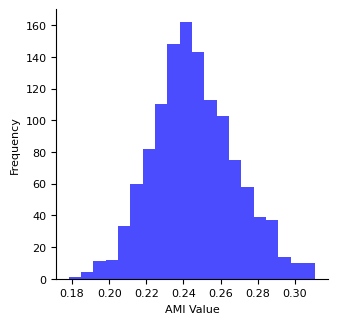

In [19]:
import matplotlib.pyplot as plt
# Set the size of the figure
plt.figure(figsize=(3.5, 3.5))

# Set the font properties
plt.rcParams.update({'font.size': 8, 'font.family': 'sans-serif'})

# Plotting the histogram without grid
plt.hist(upper_tri, bins=20, color='blue', alpha=0.7)
plt.xlabel('AMI Value')
plt.ylabel('Frequency')

# Removing the top and right axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.savefig('LDA_Stability.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Create Doc2vec Model

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [21]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

In [22]:
model_doc2vec = Doc2Vec(dm = 1, vector_size=100, window=5, seed = 42, epochs = 75)
model_doc2vec.build_vocab(tagged_data)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [23]:
get_doc_vecs = model_doc2vec.dv.index_to_key
doc_vector = []
for i in get_doc_vecs:
    doc_vector.append(model_doc2vec[i])
doc_vector = np.array(doc_vector)

In [24]:
gmm_Doc2vec = GMM(10, covariance_type='diag',max_iter= 30000, random_state = 0).fit(doc_vector)

In [25]:
xlabs = gmm_Doc2vec.predict(doc_vector)

In [26]:
from sklearn import metrics
x = metrics.silhouette_samples(doc_vector, xlabs, metric='euclidean')

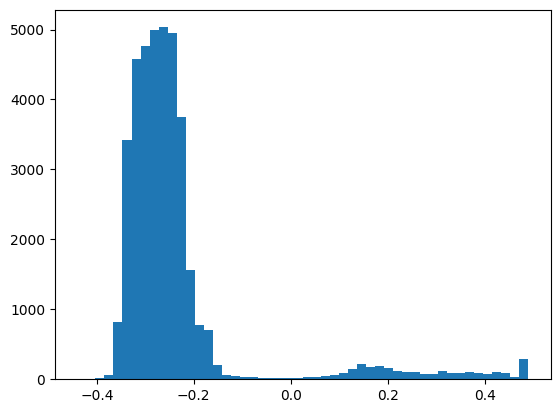

In [27]:
import matplotlib.pyplot as plt
plt.hist(x, bins=50)
plt.show()

In [21]:
df['silhouette_score'] = x

for i in np.unique(df['Docs2vec_Class_10']):
    small_df  = df[df["Docs2vec_Class_10"] == i]
    print(i,' ', np.mean(small_df['silhouette_score']))


0   0.0
1   0.24696597
2   -0.28461888
3   -0.20390967
4   0.2605252
5   -0.016065432
6   -0.22814338
7   -0.28926313
8   -0.26975697
9   -0.28721294


In [28]:
df['Docs2vec_Class_10'] = gmm_Doc2vec.predict(doc_vector)

In [26]:
# Function to run the LDA model and get predictions
def run_gmm(seed, vector_data):
    gmm_Doc2vec = GMM(10, covariance_type='diag',max_iter= 30000, random_state = seed).fit(vector_data)
    return gmm_Doc2vec.predict(vector_data)

# Running the LDA model in a loop and collecting predictions
all_predictions = []
for i in range(50):
    predict_doc = run_gmm(i, doc_vector)
    all_predictions.append(predict_doc)

# Converting the list of predictions to a DataFrame
doc2vec_df = pd.DataFrame(all_predictions).transpose()

In [27]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
# Number of columns in the DataFrame
n_columns = doc2vec_df.shape[1]

# Initializing an empty matrix for adjusted mutual information scores
ami_matrix = np.zeros((n_columns, n_columns))

# Calculating AMI for each pair of columns
for i in range(n_columns):
    for j in range(i+1, n_columns):
        ami = adjusted_mutual_info_score(doc2vec_df.iloc[:, i], doc2vec_df.iloc[:, j])
        ami_matrix[i, j] = ami
        ami_matrix[j, i] = ami  # Symmetric matrix

# Since the diagonal values are always 1 (perfect agreement with themselves), we exclude them
np.fill_diagonal(ami_matrix, 0)

In [28]:
upper_tri = ami_matrix[np.triu_indices(n_columns, k=1)]

# Calculate the standard deviation
average_ami = np.mean(upper_tri)
std_ami = np.std(upper_tri)
print(average_ami)
print(std_ami)


0.9127249646291248
0.0735209024507468


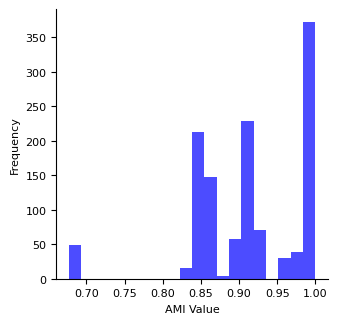

In [29]:
import matplotlib.pyplot as plt
# Set the size of the figure
plt.figure(figsize=(3.5, 3.5))

# Set the font properties
plt.rcParams.update({'font.size': 8, 'font.family': 'sans-serif'})

# Plotting the histogram without grid
plt.hist(upper_tri, bins=20, color='blue', alpha=0.7)
plt.xlabel('AMI Value')
plt.ylabel('Frequency')

# Removing the top and right axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.savefig('Doc2vec_Stability.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Create Transformer Model

In [30]:
#Create Transformer embeddings
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-MiniLM-L6-v2')
# convert twitter bios into embeddings
#embeddings = df['Bio'].map(lambda x: model.encode(x))
#embeddings = embeddings.to_frame()
#embeddings = embeddings['Bio'].apply(pd.Series)
embeddings = pd.read_csv(r'embeddings.csv')

In [31]:
gmm_Transformer = GMM(10, covariance_type='diag',max_iter= 30000, random_state = 0).fit(embeddings)

In [32]:
df['Transformer_Class_10'] = gmm_Transformer.predict(embeddings)

In [33]:
all_predictions = []
for i in range(50):
    predict_doc = run_gmm(i, embeddings)
    all_predictions.append(predict_doc)

# Converting the list of predictions to a DataFrame
LLM_df = pd.DataFrame(all_predictions).transpose()

In [34]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
#from sklearn.metrics.cluster import normalized_mutual_info_score
# Number of columns in the DataFrame
n_columns = LLM_df.shape[1]

# Initializing an empty matrix for adjusted mutual information scores
ami_matrix = np.zeros((n_columns, n_columns))

# Calculating AMI for each pair of columns
for i in range(n_columns):
    for j in range(i+1, n_columns):
        ami = adjusted_mutual_info_score(LLM_df.iloc[:, i], LLM_df.iloc[:, j])
        ami_matrix[i, j] = ami
        ami_matrix[j, i] = ami  # Symmetric matrix

# Since the diagonal values are always 1 (perfect agreement with themselves), we exclude them
np.fill_diagonal(ami_matrix, 0)

In [35]:
upper_tri = ami_matrix[np.triu_indices(n_columns, k=1)]

# Calculate the standard deviation
average_ami = np.mean(upper_tri)
std_ami = np.std(upper_tri)
print(average_ami)
print(std_ami)

0.7861726334425685
0.092534658668003


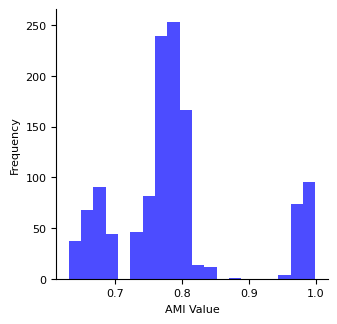

In [36]:
import matplotlib.pyplot as plt
# Set the size of the figure
plt.figure(figsize=(3.5, 3.5))

# Set the font properties
plt.rcParams.update({'font.size': 8, 'font.family': 'sans-serif'})

# Plotting the histogram without grid
plt.hist(upper_tri, bins=20, color='blue', alpha=0.7)
plt.xlabel('AMI Value')
plt.ylabel('Frequency')

# Removing the top and right axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.savefig('LLM_Stability.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [37]:
upper_tri = ami_matrix[np.triu_indices(n_columns, k=1)]

# Calculate the standard deviation
average_ami = np.mean(upper_tri)
std_ami = np.std(upper_tri)
print(average_ami)
print(std_ami)


0.7708333088512901
0.0938451031742021


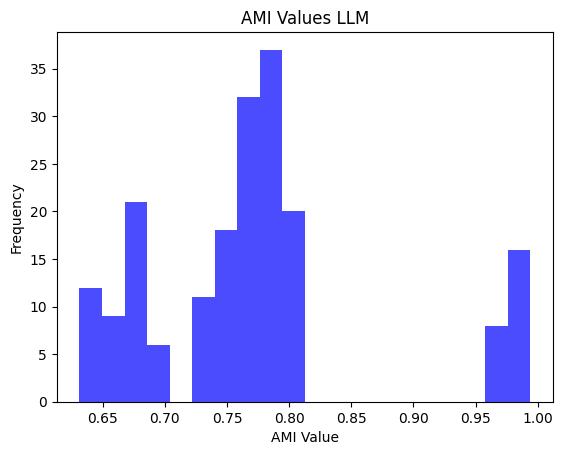

In [49]:
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(upper_tri, bins=20, color='blue', alpha=0.7)
plt.title('AMI Values LLM')
plt.xlabel('AMI Value')
plt.ylabel('Frequency')
#plt.grid(True)
plt.show()

In [38]:
upper_tri

array([0.98369957, 0.7633425 , 0.75568547, 0.75421307, 0.98592564,
       0.9890458 , 0.77716547, 0.67073981, 0.75575153, 0.79904859,
       0.76512893, 0.79783933, 0.67347635, 0.79858805, 0.79858622,
       0.75460524, 0.77836032, 0.79837309, 0.67308262, 0.76296279,
       0.75488991, 0.75336275, 0.97667679, 0.97861487, 0.77983936,
       0.67010613, 0.75508961, 0.80270658, 0.76453751, 0.80018442,
       0.67280018, 0.80212755, 0.80253708, 0.75712036, 0.78118006,
       0.80249086, 0.67222479, 0.63233364, 0.63250334, 0.76381451,
       0.76414561, 0.65131872, 0.63868227, 0.63105912, 0.74026957,
       0.99034345, 0.73512662, 0.64268572, 0.73439644, 0.73606511,
       0.65954843, 0.65051771, 0.74034809, 0.64376515, 0.96216826,
       0.75527131, 0.75606251, 0.77658338, 0.66861956, 0.98293811,
       0.7665465 , 0.63223968, 0.76476219, 0.67209104, 0.76372322,
       0.76415054, 0.7351411 , 0.77692515, 0.76589048, 0.67276029,
       0.75387931, 0.75471148, 0.77533498, 0.67002328, 0.96501

In [47]:
std_array = np.array(gmm_Transformer.covariances_)
np.mean(std_array,axis = 1)
#scaled_array = np.mean(np.array((std_array-np.min(std_array))/(np.max(std_array)-np.min(std_array))), axis = 1)
#scaled_array

array([0.00172996, 0.00195426, 0.00190128, 0.00201813, 0.00176372,
       0.00232332, 0.00191329, 0.0021705 , 0.00146488, 0.00169833])

# Create Random Model

In [8]:
from random import randrange, seed
seed(0)
rand_col = []
for i in range(len(df)):
    rand_col.append(randrange(10))
df['random_clusters'] = rand_col

In [11]:
top_words_rand = []
for i in np.unique(df['random_clusters']):
        small_df = df[df["random_clusters"] == i]
        top_words_rand.append(get_most_freq_words(small_df["Bios"], 10))

In [16]:
transformer_coherence =   CoherenceModel(topics=top_words_rand, texts=tokenized_doc, dictionary=dictionary, coherence='c_v')
transformer_coherence.get_coherence_per_topic()

C:\Users\justi\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\justi\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

# Get Top Words - Transformer

In [9]:
def get_most_freq_words(documents, n_top =10):
    corpus1 = []
    for d in documents:
        corpus1.append(str(d))
    vec = CountVectorizer(stop_words='english').fit(corpus1)
    bag_of_words = vec.transform(corpus1)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq1 = [x[0] for x in words_freq]
    return words_freq1[0:n_top]

In [10]:
from gensim.models.coherencemodel import CoherenceModel

In [22]:
top_words_trans10 = []
for i in np.unique(df['Transformer_Class_10']):
        small_df = df[df["Transformer_Class_10"] == i]
        top_words_trans10.append(get_most_freq_words(small_df["Bios"], 10))

In [24]:
transformer_coherence =   CoherenceModel(topics=top_words_trans10, texts=tokenized_doc, dictionary=dictionary, coherence='u_mass')

In [26]:
transformer_coherence.get_coherence_per_topic()

[-2.5899815130777104,
 -3.1978322647555655,
 -2.7699274478904257,
 -4.140993779044944,
 -2.853581692570847,
 -7.729550629139106,
 -8.06059534992601,
 -7.64715115512365,
 -1.8726739393481286,
 -2.619508995335336]

In [ ]:
#Gets the 10 most frequent words for each cluster
top_words_trans10 = []
for i in np.unique(df['Transformer_Class_10']):
        small_df = df[df["Transformer_Class_10"] == i]
        top_words_trans10.append(get_most_freq_words(small_df["Bios"], 10))
transformer_coherence =   CoherenceModel(topics=top_words_trans10, texts=tokenized_doc, dictionary=dictionary, coherence='c_v')
all_coherence = transformer_coherence.get_coherence_per_topic()
print(all_coherence)

In [22]:
#Inserts the emojis back into the top 10 words
top_all = []
for i in top_words_trans10:
    top_topic = []
    for j in i:
        emoj_word = emojize(':'+j+':').replace(':','')
        if is_emoji(emoj_word):
            top_topic.append(emoj_word)
        else:
              top_topic.append(emojize(':' + emoj_word.replace("_", " " ).title().replace(' ', "_") + ':').replace(':',''))
    top_all.append(top_topic)

# Get Top Words - Doc2vec

In [27]:
top_words_doc10 = []
for i in np.unique(df['Docs2vec_Class_10']):
        small_df = df[df["Docs2vec_Class_10"] == i]
        top_words_doc10.append(get_most_freq_words(small_df["Bios"], 10))
Doc_coherence =   CoherenceModel(topics=top_words_doc10, texts=tokenized_doc, dictionary=dictionary, coherence='u_mass')
Doc_all_coherence = Doc_coherence.get_coherence_per_topic()
print(Doc_all_coherence)
        
top_all_docs = []
for i in top_words_doc10:
    top_topic = []
    for j in i:
        emoj_word = emojize(':'+j+':').replace(':','')
        if is_emoji(emoj_word):
            top_topic.append(emoj_word)
        else:
              top_topic.append(emojize(':' + emoj_word.replace("_", " " ).title().replace(' ', "_") + ':').replace(':',''))
    top_all_docs.append(top_topic)

[-2.6709524607048336, -3.9462157729929705, -2.8815027187135014, -2.671147579968458, -2.797360331280367, -3.2919318193266096, -2.288875138361903, -2.6999991856447236, -2.7983851062319545, -2.6131944166739363]


# Get Top Words LDA

In [29]:
#Get the top words for each topic
topic_words_lda = []
num_topics = 10
for i in range(num_topics):
    tt = goodLdaModel.get_topic_terms(i,10)
    topic_words_lda.append([dictionary[pair[0]] for pair in tt])
LDA_coherence =   CoherenceModel(topics=topic_words_lda, texts=tokenized_doc, dictionary=dictionary, coherence='u_mass')
LDA_all_coherence = LDA_coherence.get_coherence_per_topic()
print(LDA_all_coherence)


LDA_test = CoherenceModel(model=goodLdaModel, texts=tokenized_doc, dictionary=dictionary, coherence='u_mass')
print(LDA_test.get_coherence_per_topic())

[-3.503113265878975, -2.08259720338761, -3.986339545668767, -2.605293835680971, -3.2654362041288576, -3.5265750149035435, -3.6373761744608135, -8.29009492160513, -8.83448547182182, -4.387428199000391]
[-3.680900495591216, -2.45204047684286, -4.70347330142563, -3.770568537837743, -3.4714879913600165, -4.812692245037309, -5.262953391193617, -8.753879773707482, -9.132827092787085, -4.111566938941183]


In [25]:
#reinsert the emojis that had been taken out
top_all_lda = []
for i in topic_words_lda:
    top_topic = []
    for j in i:
        emoj_word = emojize(':'+j+':').replace(':','')
        if is_emoji(emoj_word):
            top_topic.append(emoj_word)
        else:
              top_topic.append(emojize(':' + emoj_word.replace("_", " " ).title().replace(' ', "_") + ':').replace(':',''))
    top_all_lda.append(top_topic)

In [26]:
def get_sample_cluster(df, model_name, model_number, n_sample, random_state):
    small_df = df[df[model_name] == model_number]
    return small_df.sample(n=n_sample, random_state = random_state)
    

# Sample Bios 1

In [27]:
random.seed(0)
unique_vals = np.unique(df["random_clusters"])
rand_10 = pd.DataFrame()
for i in unique_vals:
   rand_10[str(i)] =  get_sample_cluster(df, "random_clusters",i, 20, random_state= 1).Bio_emoji.values
    

In [28]:
rand_10.to_csv('Random_Sample_1.csv', index= False)

In [29]:
random.seed(0)
unique_vals = np.unique(df["Docs2vec_Class_10"])
Doc_10 = pd.DataFrame()
for i in unique_vals:
   Doc_10[str(i)] =  get_sample_cluster(df, "Docs2vec_Class_10",i, 20, random_state= 1).Bio_emoji.values
    

In [30]:
Doc_10.to_csv('Doc_Sample_1.csv', index= False)

In [31]:
random.seed(0)
unique_vals = np.unique(df["LDA_Class_10"])
LDA_10 = pd.DataFrame()
for i in unique_vals:
   LDA_10[str(i)] =  get_sample_cluster(df, "LDA_Class_10",i, 20, random_state= 1).Bio_emoji.values
    

In [32]:
LDA_10.to_csv('LDA_Sample_1.csv', index= False)

In [33]:
random.seed(0)
unique_vals = np.unique(df["Transformer_Class_10"])
trans_10 = pd.DataFrame()
for i in unique_vals:
   trans_10[str(i)] =  get_sample_cluster(df, "Transformer_Class_10",i, 20, random_state= 1).Bio_emoji.values

In [34]:
trans_10.to_csv('Transformer_Sample_1.csv', index= False)

# Sample Bios 2

In [35]:
random.seed(1)
unique_vals = np.unique(df["random_clusters"])
rand_10 = pd.DataFrame()
for i in unique_vals:
   rand_10[str(i)] =  get_sample_cluster(df, "random_clusters",i, 20, random_state= 1).Bio_emoji.values
    

In [36]:
rand_10.to_csv('Random_Sample_2.csv', index= False)

In [37]:
random.seed(1)
unique_vals = np.unique(df["Docs2vec_Class_10"])
Doc_10 = pd.DataFrame()
for i in unique_vals:
   Doc_10[str(i)] =  get_sample_cluster(df, "Docs2vec_Class_10",i, 20, random_state= 1).Bio_emoji.values
    

In [38]:
Doc_10.to_csv('Doc_Sample_2.csv', index= False)

In [39]:
random.seed(1)
unique_vals = np.unique(df["LDA_Class_10"])
LDA_10 = pd.DataFrame()
for i in unique_vals:
   LDA_10[str(i)] =  get_sample_cluster(df, "LDA_Class_10",i, 20, random_state= 1).Bio_emoji.values
    

In [40]:
LDA_10.to_csv('LDA_Sample_2.csv', index= False)

In [41]:
random.seed(1)
unique_vals = np.unique(df["Transformer_Class_10"])
trans_10 = pd.DataFrame()
for i in unique_vals:
   trans_10[str(i)] =  get_sample_cluster(df, "Transformer_Class_10",i, 20, random_state= 1).Bio_emoji.values

In [42]:
trans_10.to_csv('Transformer_Sample_2.csv', index= False)

# Sample Bios 3

In [43]:
random.seed(2)
unique_vals = np.unique(df["random_clusters"])
rand_10 = pd.DataFrame()
for i in unique_vals:
   rand_10[str(i)] =  get_sample_cluster(df, "random_clusters",i, 20, random_state= 2).Bio_emoji.values
    

In [44]:
rand_10.to_csv('Random_Sample_3.csv', index= False)

In [45]:
random.seed(2)
unique_vals = np.unique(df["Docs2vec_Class_10"])
Doc_10 = pd.DataFrame()
for i in unique_vals:
   Doc_10[str(i)] =  get_sample_cluster(df, "Docs2vec_Class_10",i, 20, random_state= 2).Bio_emoji.values
    

In [46]:
Doc_10.to_csv('Doc_Sample_3.csv', index= False)

In [47]:
random.seed(2)
unique_vals = np.unique(df["LDA_Class_10"])
LDA_10 = pd.DataFrame()
for i in unique_vals:
   LDA_10[str(i)] =  get_sample_cluster(df, "LDA_Class_10",i, 20, random_state= 2).Bio_emoji.values
    

In [48]:
LDA_10.to_csv('LDA_Sample_3.csv', index= False)

In [49]:
random.seed(2)
unique_vals = np.unique(df["Transformer_Class_10"])
trans_10 = pd.DataFrame()
for i in unique_vals:
   trans_10[str(i)] =  get_sample_cluster(df, "Transformer_Class_10",i, 20, random_state= 2).Bio_emoji.values

In [50]:
trans_10.to_csv('Transformer_Sample_3.csv', index= False)

# Sample Bios 4

In [51]:
random.seed(3)
unique_vals = np.unique(df["random_clusters"])
rand_10 = pd.DataFrame()
for i in unique_vals:
   rand_10[str(i)] =  get_sample_cluster(df, "random_clusters",i, 20, random_state= 3).Bio_emoji.values
    

In [52]:
rand_10.to_csv('Random_Sample_4.csv', index= False)

In [53]:
random.seed(3)
unique_vals = np.unique(df["Docs2vec_Class_10"])
Doc_10 = pd.DataFrame()
for i in unique_vals:
   Doc_10[str(i)] =  get_sample_cluster(df, "Docs2vec_Class_10",i, 20, random_state= 3).Bio_emoji.values
    

In [54]:
Doc_10.to_csv('Doc_Sample_4.csv', index= False)

In [55]:
random.seed(3)
unique_vals = np.unique(df["LDA_Class_10"])
LDA_10 = pd.DataFrame()
for i in unique_vals:
   LDA_10[str(i)] =  get_sample_cluster(df, "LDA_Class_10",i, 20, random_state= 3).Bio_emoji.values
    

In [56]:
LDA_10.to_csv('LDA_Sample_4.csv', index= False)

In [57]:
random.seed(3)
unique_vals = np.unique(df["Transformer_Class_10"])
trans_10 = pd.DataFrame()
for i in unique_vals:
   trans_10[str(i)] =  get_sample_cluster(df, "Transformer_Class_10",i, 20, random_state= 3).Bio_emoji.values

In [58]:
trans_10.to_csv('Transformer_Sample_4.csv', index= False)

In [62]:
com_vals

,Political Leaning,Transformer_Class,size,percent
0,Democrat,0,2638,0.802556
1,Democrat,1,2086,0.645221
2,Democrat,2,2891,0.514230
3,Democrat,3,2102,0.594121
4,Democrat,4,1568,0.501439
5,Democrat,5,2856,0.391233
6,Democrat,6,988,0.495486
7,Democrat,7,2017,0.500745
8,Democrat,8,59,0.018683
9,Democrat,9,1052,0.363009


In [5]:
df.head()

,User_handles,Bios,Class,Number,Bio_emoji
0,ElizabethEv,"A generally optimistic wife + mother | writer,...",Democrat,1.0,"A generally optimistic wife + mother | writer,..."
1,AloeLanding,"Following US politics, local and world news an...",Democrat,1.0,"Following US politics, local and world news an..."
2,scburdet,Completely transparent chemistry troll. Runner...,Non Political,2.0,Completely transparent chemistry troll. Runner...
3,Sanjosebrandon,"I follow God, what’s in my heart and others th...",Non Political,2.0,"I follow God, what’s in my heart and others th..."
4,Gigi2my3,:raised_hand:DM :prohibited::victory_hand:Vega...,Democrat,0.0,:raised_hand:DM :prohibited::victory_hand:Vega...


# Comparing Clustering with Political Affiliation

In [9]:
from mizani.formatters import percent_format
from plotnine import *
from mizani.formatters import percent_format
from plotnine import *
com_vals = pd.DataFrame(df.groupby(['Class','Transformer_Class_10'], as_index=False).size())
com_vals['percent'] =  com_vals['size'] / com_vals.groupby('Transformer_Class_10')['size'].transform('sum')
com_vals.columns = ['Political Leaning', 'Transformer_Class','size','percent']


In [10]:
com_vals['Transformer_Class'] = com_vals['Transformer_Class'].astype(str)
com_vals['Transformer_Class'] = com_vals['Transformer_Class'].replace(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ['Left-leaning', 'Artistic bios', 'Political', 'Occupations', 'Relational', 'General bios', 'Meta Bios', 'Quotes', 'Right-leaning', 'Emojis'])

In [11]:
com_vals

,Political Leaning,Transformer_Class,size,percent
0,Democrat,Left-leaning,2638,0.802556
1,Democrat,Artistic bios,2086,0.645221
2,Democrat,Political,2891,0.514230
3,Democrat,Occupations,2102,0.594121
4,Democrat,Relational,1568,0.501439
5,Democrat,General bios,2856,0.391233
6,Democrat,Meta Bios,988,0.495486
7,Democrat,Quotes,2017,0.500745
8,Democrat,Right-leaning,59,0.018683
9,Democrat,Emojis,1052,0.363009


In [12]:
vis_plot = (ggplot(com_vals, aes(x='Transformer_Class',y = 'percent', fill = 'Political Leaning')) +
            geom_col() +
            #scale_x_continuous(breaks = np.arange(0,10,1)) +
            scale_fill_manual(['#0D5E8D','#8BB5D4','#982C18','yellow']) +
            xlab('Cluster') +
            ylab('Percentage of bios by Political Affiliation') +
            theme(figure_size=(16, 12),
        legend_position= (0.5, -0.35),
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.7,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major= element_blank(),#element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=20, family="Tahoma", 
                                face="bold"),
        text=element_text(family="Tahoma", size=20),
        axis_text_x=element_text(colour="black", size=20, angle = 90),
        axis_text_y=element_text(colour="black", size=20),
    ) +
            scale_y_continuous(limits = [0,1],labels=percent_format()))
vis_plot 
vis_plot.save(filename = 'Transformer_Pol_Dis.pdf', height=18, width=22, units = 'cm', dpi=1200)

C:\Users\justi\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 22.000000000000004 x 18.0 cm image.
C:\Users\justi\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: Transformer_Pol_Dis.pdf


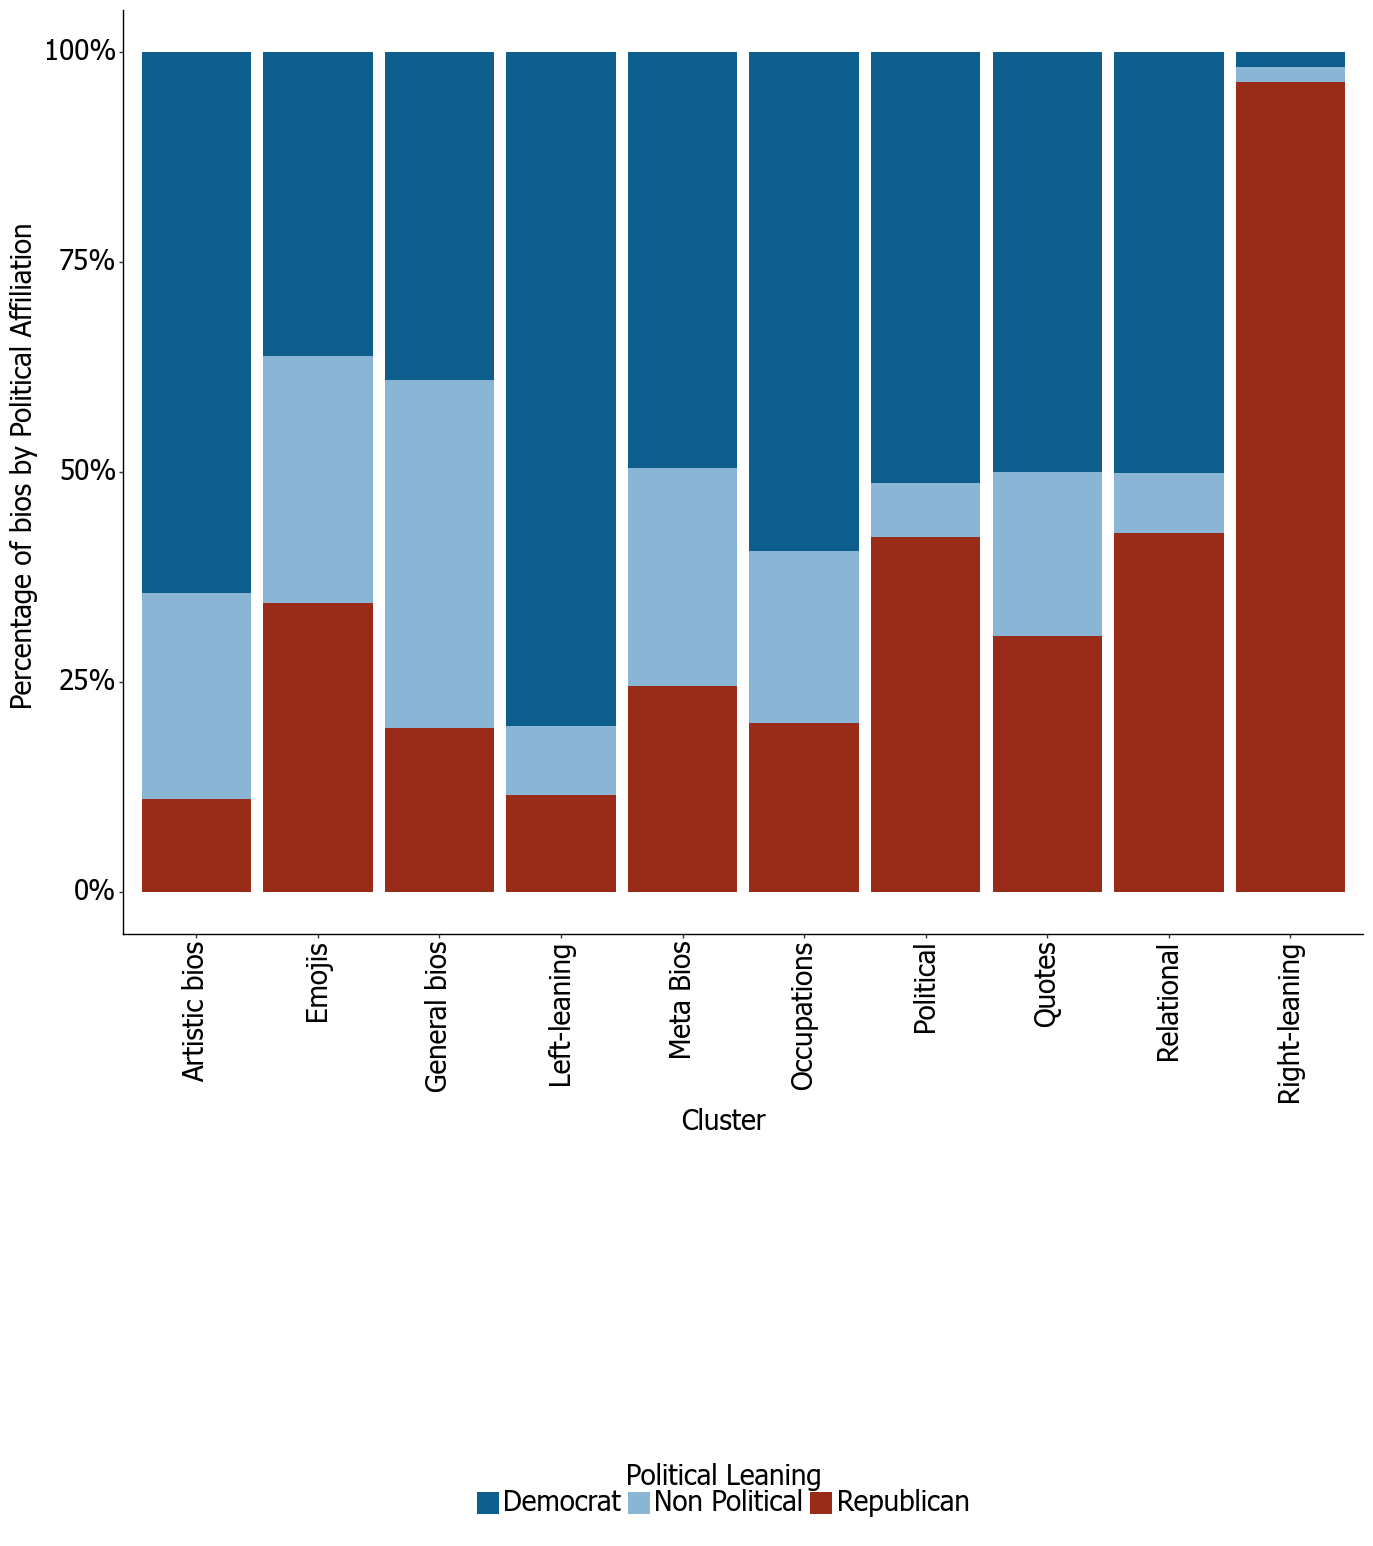

<ggplot: (163716195533)>

In [13]:
vis_plot